In [1]:
import math

import torch
from torch import nn

In [2]:
import torch
import torch.nn as nn
import math
import torch.nn.functional as F


class ConvolutionalBlock(nn.Module):
    def __init__(self, input_length, features, stride=2, padding=1, kernel_size=4, batch_norm=True):
        super(ConvolutionalBlock, self).__init__()
        self.convolution = nn.Conv2d(input_length, features, kernel_size, stride, padding)
        self.layer = nn.Sequential(self.convolution)
        if batch_norm:
            self.layer.append(nn.BatchNorm2d(features))
        self.layer.append(nn.LeakyReLU(0.2, True))
        torch.nn.init.normal_(self.convolution.weight, 0, 0.02)

    def forward(self, x):
        return self.layer(x)


class DeconvolutionalBlock(nn.Module):
    def __init__(self, input_length, features, stride=2, padding=1, kernel_size=4, output_padding=0):
        super(DeconvolutionalBlock, self).__init__()
        self.convolution = nn.ConvTranspose2d(
            input_length, features, kernel_size, stride, padding, output_padding=output_padding
        )
        self.batch_normalization = nn.BatchNorm2d(features)
        self.activation = nn.ReLU(True)
        self.layer = nn.Sequential(self.convolution, self.batch_normalization, self.activation)
        torch.nn.init.normal_(self.convolution.weight, 0, 0.02)

    def forward(self, x):
        return self.layer(x)


class DropOutBlock(DeconvolutionalBlock):
    def __init__(self, input_length, features, stride=2, padding=1, kernel_size=4, output_padding=0):
        super(DropOutBlock, self).__init__(input_length, features, stride, padding, kernel_size, output_padding)
        self.layer = nn.Sequential(
            self.convolution,
            self.batch_normalization,
            nn.Dropout(p=0.5),
            self.activation
        )


class Generator(nn.Module):
    def __init__(self, input_channels, output_channels, image_size):
        super(Generator, self).__init__()
        features = 64
        layer_num = int(math.log(image_size, 2) - 2)

        # Encoder blocks
        self.encoders = nn.ModuleList()
        self.encoders.append(
            ConvolutionalBlock(input_channels, features, kernel_size=4, stride=2, padding=1, batch_norm=False)
        )

        input_factor = 0
        output_factor = 0

        for i in range(layer_num):
            input_factor = min(8, int(2 ** i))
            output_factor = min(8, input_factor * 2)
            self.encoders.append(ConvolutionalBlock(features * input_factor, features * output_factor))

        self.encoders.append(
            ConvolutionalBlock(features * output_factor, features * output_factor, batch_norm=False)
        )

        # Decoder blocks
        dropout_num = 3
        self.decoders = nn.ModuleList()
        self.decoders.append(DropOutBlock(features * output_factor, features * output_factor))

        for i in range(layer_num):
            input_factor = min(8 * 2, int(2 ** (layer_num - i)) * 2)
            output_factor = min(8, int(2 ** (layer_num - i) / 2))

            # Calculate the output padding to match the sizes
            output_padding = 1 if (i < layer_num - 1 and i >= dropout_num - 1) else 0

            if i < dropout_num - 1:
                self.decoders.append(DropOutBlock(features * input_factor, features * output_factor,
                                                  output_padding=output_padding))
            else:
                self.decoders.append(DeconvolutionalBlock(features * input_factor, features * output_factor,
                                                          output_padding=output_padding))

        self.decoders.append(
            nn.ConvTranspose2d(features * output_factor * 2, output_channels, kernel_size=4, stride=2, padding=1)
        )
        self.tanh = torch.nn.Tanh()



    def forward(self, x):
        # Encoder path
        encoder_x = [x]
        for i in range(len(self.encoders)):
            encoder_x.append(self.encoders[i](encoder_x[i]))

        # Decoder path
        decoder_x = encoder_x[-1]
        for i in range(len(self.decoders) - 1):
            decoder_x = self.decoders[i](decoder_x)

            # Get the corresponding encoder output
            encoder_out = encoder_x[-i - 2]

            # Dynamically pad the decoder output if shapes don't match
            if decoder_x.shape[2:] != encoder_out.shape[2:]:
                diff_h = encoder_out.shape[2] - decoder_x.shape[2]
                diff_w = encoder_out.shape[3] - decoder_x.shape[3]

                # Apply padding (left, right, top, bottom)
                decoder_x = F.pad(decoder_x, [0, diff_w, 0, diff_h])

            # Concatenate along the channel dimension
            decoder_x = torch.cat([decoder_x, encoder_out], dim=1)

        # Final layer without concatenation
        decoder_x = self.decoders[-1](decoder_x)
        return self.tanh(decoder_x)



In [3]:
import torch
import torch.nn as nn
from torchsummary import summary
import numpy as np


# Define device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Hyperparameters
input_channels = 3     # For RGB images
output_channels = 1    # For RGB output images
image_size = 768       # Size of the input image (assuming square)

# Initialize the Generator model
model = Generator(input_channels=input_channels, output_channels=output_channels, image_size=image_size).to(device)

# Print model summary
summary(model, input_size=(input_channels, image_size, image_size))

# Create a dummy input tensor with batch size of 1
input_tensor = torch.randn(1, input_channels, image_size, image_size).to(device)

# Pass the dummy input through the generator
with torch.no_grad():
    output_tensor = model(input_tensor)

print(f"Input shape: {input_tensor.shape}")
print(f"Output shape: {output_tensor.shape}")

# Optionally, save the model
torch.save(model.state_dict(), "generator.pth")
print("Model saved as generator.pth")

Using device: cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 384, 384]           3,136
            Conv2d-2         [-1, 64, 384, 384]           3,136
         LeakyReLU-3         [-1, 64, 384, 384]               0
ConvolutionalBlock-4         [-1, 64, 384, 384]               0
            Conv2d-5        [-1, 128, 192, 192]         131,200
            Conv2d-6        [-1, 128, 192, 192]         131,200
       BatchNorm2d-7        [-1, 128, 192, 192]             256
         LeakyReLU-8        [-1, 128, 192, 192]               0
ConvolutionalBlock-9        [-1, 128, 192, 192]               0
           Conv2d-10          [-1, 256, 96, 96]         524,544
           Conv2d-11          [-1, 256, 96, 96]         524,544
      BatchNorm2d-12          [-1, 256, 96, 96]             512
        LeakyReLU-13          [-1, 256, 96, 96]               0
ConvolutionalBlock-1

Epoch [1/100], Loss: 0.447413
Epoch [2/100], Loss: 0.343596
Epoch [3/100], Loss: 0.277191
Epoch [4/100], Loss: 0.225155
Epoch [5/100], Loss: 0.183220
Epoch [6/100], Loss: 0.150073
Epoch [7/100], Loss: 0.123778
Epoch [8/100], Loss: 0.103567
Epoch [9/100], Loss: 0.088363
Epoch [10/100], Loss: 0.077259
Epoch [11/100], Loss: 0.068632
Epoch [12/100], Loss: 0.061920
Epoch [13/100], Loss: 0.056873
Epoch [14/100], Loss: 0.052751
Epoch [15/100], Loss: 0.049266
Epoch [16/100], Loss: 0.046252
Epoch [17/100], Loss: 0.043583
Epoch [18/100], Loss: 0.041203
Epoch [19/100], Loss: 0.038994
Epoch [20/100], Loss: 0.036934
Epoch [21/100], Loss: 0.034942
Epoch [22/100], Loss: 0.032976
Epoch [23/100], Loss: 0.031033
Epoch [24/100], Loss: 0.029190
Epoch [25/100], Loss: 0.027521
Epoch [26/100], Loss: 0.025703
Epoch [27/100], Loss: 0.024096
Epoch [28/100], Loss: 0.022684
Epoch [29/100], Loss: 0.024028
Epoch [30/100], Loss: 0.038008
Epoch [31/100], Loss: 0.029153
Epoch [32/100], Loss: 0.025958
Epoch [33/100], L

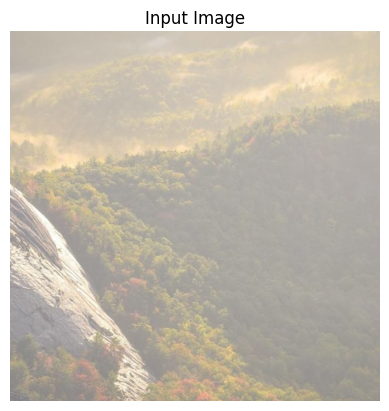

Using device: cuda


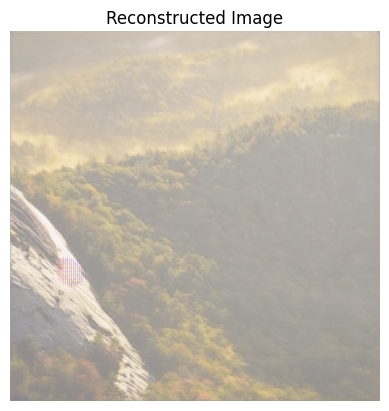

Using device: cuda


In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Function to visualize images
def show_image(img, title="Image"):
    img = img.detach().cpu().squeeze(0).permute(1, 2, 0).numpy()
    plt.imshow((img + 1) / 2)  # Rescale to [0, 1] if using Tanh
    plt.title(title)
    plt.axis('off')
    plt.show()

    # Set the device (GPU if available, else CPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

# Hyperparameters
input_channels = 3
output_channels = 3
image_size = 768  # Smaller size for faster overfitting test
learning_rate = 0.0002
epochs = 1000

# Initialize the Generator model
model = Generator(input_channels, output_channels, image_size).to(device)
model.train()

#Load image.jpg into a tensor
from PIL import Image
import torchvision.transforms as transforms

image_path = "image.jpg"
image = Image.open(image_path)

input_tensor = transforms.ToTensor()(image).unsqueeze(0).to(device)

# Use the same image as the target output (overfitting test)
target_tensor = input_tensor.clone()

# Define the loss function (Mean Squared Error Loss)
criterion = nn.MSELoss()

# Define the optimizer (Adam)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.5, 0.999))

# Training loop
for epoch in range(epochs):
    optimizer.zero_grad()

    # Forward pass through the model
    output_tensor = model(input_tensor)

    # Calculate loss
    loss = criterion(output_tensor, target_tensor)

    # Backpropagation and optimization step
    loss.backward()
    optimizer.step()

    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.6f}")

# Show the input and output images
print("Training complete. Displaying results...")
show_image(input_tensor, "Input Image")
show_image(output_tensor, "Reconstructed Image")